# Task 1. Vigenère Algorithm

In [454]:
KEYWORD = "KEY"
SEQ_LEN = 3
MAX_KEY_LEN = 20
EN_REL_FREQ = {'A': 0.08167, 'B': 0.01492, 'C': 0.02782, 'D': 0.04253, 'E': 0.12702, 'F': 0.02228, 'G': 0.02015,
               'H': 0.06094, 'I': 0.06966, 'J': 0.00153, 'K': 0.00772, 'L': 0.04025, 'M': 0.02406, 'N': 0.06749,
               'O': 0.07507, 'P': 0.01929, 'Q': 0.00095, 'R': 0.05987, 'S': 0.06327, 'T': 0.09056, 'U': 0.02758,
               'V': 0.00978, 'W': 0.02360, 'X': 0.00150, 'Y': 0.01974, 'Z': 0.00074}
ALPHABET = list(EN_REL_FREQ.keys())

In [455]:
string_to_encrypt = "CRYPTOGRAPHYANDDATASECURITY"

In [456]:
from collections import defaultdict


def _make_encrypt_table(alphabet: list[str], key_word: str):
    encrypt_table = defaultdict(list)
    for ch in key_word:
        dist = ord(ch) - ord(alphabet[0])
        encrypt_table[ch] = alphabet[dist:] + alphabet[:dist]
    return encrypt_table

In [457]:
def _full_string_with_keyword(s: str, key_word: str):
    key_line = key_word * int(len(s) / len(key_word))
    ost = int(len(s) % len(key_word))
    key_line += key_word[:ost]
    return key_line

In [458]:
def encrypt_string(s: str, alphabet: list[str] = ALPHABET, key_word: str = KEYWORD):
    s = s.upper()
    encrypt_table = _make_encrypt_table(alphabet, key_word)
    key_line = _full_string_with_keyword(s, key_word)
    encrypted_str = ""
    for ind in range(len(key_line)):
        if s[ind] not in alphabet:
            encrypted_str += s[ind]
            continue
        pos_in_alphabet = alphabet.index(s[ind])
        encrypted_str += encrypt_table[key_line[ind]][pos_in_alphabet]
    return encrypted_str

In [459]:
encrypted_string = encrypt_string(string_to_encrypt)
encrypted_string

'MVWZXMQVYZLWKRBNERKWCMYPSXW'

## Encrypting large strings

In [460]:
needed_lines_length = [5000, 10000]
lines = []
data_path = '../data/harry_potter.txt'

In [461]:
with open(data_path, 'r') as file:
    s = file.read()
    s = ''.join(char for char in s if char.isalnum()).upper()
    prev_str_end = 0
    for length in needed_lines_length:
        lines.append(s[prev_str_end:prev_str_end + length])
        prev_str_end = length

In [462]:
encrypted_lines = [
    encrypt_string(line) for line in lines
]

# Decryption

## Helper functions

In [463]:
def get_blocks(text, size):
    blocks = [text[i:i + size] for i in range(0, len(text) - size, size)]
    return blocks


def get_columns(text_blocks):
    group_size = len(text_blocks[0])
    columns = []
    for letter_count in range(group_size):
        column = ''
        for group_count in range(len(text_blocks)):
            column += text_blocks[group_count][letter_count]
        columns.append(column)
    return columns


def to_blocks(cols):
    col_size = len(cols[0])
    blocks = []
    for letter in range(col_size):
        block = ''
        for col in range(len(cols)):
            block += cols[col][letter]
        blocks.append(block)
    return blocks

## Find keyword's len with Kasiski method

In [464]:
from math import sqrt


def _repeated_seq_pos(text, seq_len):
    seq_pos = {}  # entries of sequence : [positions]
    for i, char in enumerate(text):
        next_seq = text[i:i + seq_len]
        if next_seq in seq_pos.keys():
            seq_pos[next_seq].append(i)
        else:
            seq_pos[next_seq] = [i]
    repeated = list(filter(lambda x: len(seq_pos[x]) >= 2, seq_pos))
    rep_seq_pos = [(seq, seq_pos[seq]) for seq in repeated]
    return rep_seq_pos


def _get_spacings(positions):
    return [positions[i + 1] - positions[i] for i in range(len(positions) - 1)]


def _get_factors(number):
    factors = set()
    for i in range(1, int(sqrt(number)) + 1):
        if number % i == 0:
            factors.add(i)
            factors.add(number // i)
    return sorted(factors)


def _candidate_key_lengths(factor_lists, max_key_len):
    all_factors = [factor_lists[lst][fac] for lst in range(len(factor_lists)) for fac in range(len(factor_lists[lst]))]
    # exclude factors larger than suspected max key length
    candidate_lengths = list(filter(lambda x: 2 < x <= max_key_len, all_factors))
    # sort by probability (descending)
    sorted_candidates = sorted(set(candidate_lengths), key=lambda x: (all_factors.count(x), x), reverse=True)
    return sorted_candidates


def find_key_length(cyphertext, seq_len, max_key_len):
    # find repeated sequences and their positions
    rsp = _repeated_seq_pos(text=cyphertext, seq_len=seq_len)
    seq_spc = {}
    for seq, positions in rsp:
        seq_spc[seq] = _get_spacings(positions)
    # calculate spacings between positions of each repeated
    # sequence and factor out spacings
    factor_lists = []
    for spacings in seq_spc.values():
        for space in spacings:
            factor_lists.append(_get_factors(number=space))
    # get common factors by descending frequency,
    # which constitute candidate key lengths
    ckl = _candidate_key_lengths(factor_lists=factor_lists, max_key_len=max_key_len)
    if len(ckl) == 0:
        raise ValueError("Could not attack provided cyphertext")
    key_len = ckl[0]
    return key_len

## Guessing keywords with its length

In [465]:
import string


def get_letter_counts(text):
    text_upper = text.upper()
    letter_counts = {}
    for index, letter in enumerate(string.ascii_uppercase):
        letter_counts[letter] = text_upper.count(letter)
    return letter_counts


def _get_letter_frequencies(text):
    letter_counts = get_letter_counts(text)
    frequencies = {letter: count / len(text) for letter, count in letter_counts.items()}
    return frequencies


def shift(text, amount):
    shifted = ''
    letters = string.ascii_uppercase
    for letter in text:
        shifted += letters[(letters.index(letter) - amount) % len(letters)]
    return shifted


def _corr(text, lf):
    return sum([(lf[letter] * EN_REL_FREQ[letter]) for letter in text])


def _find_key_letter(text, lf):
    key_letter = ''
    max_corr = 0
    for count, letter in enumerate(string.ascii_uppercase):
        shifted = shift(text=text, amount=count)
        corr = _corr(text=shifted, lf=lf)
        if corr > max_corr:
            max_corr = corr
            key_letter = letter
    return key_letter


def restore_key(cyphertext, key_len):
    key = ''
    blocks = get_blocks(text=cyphertext, size=key_len)
    columns = get_columns(blocks)
    frequencies = _get_letter_frequencies(text=cyphertext)
    for column in columns:
        key += _find_key_letter(text=column, lf=frequencies)
    return key

In [466]:
def decypher(cyphertext, key):
    letters = string.ascii_uppercase
    shifts = [letters.index(letter) for letter in key]
    blocks = get_blocks(text=cyphertext, size=len(key))
    cols = get_columns(blocks)
    decyphered_blocks = to_blocks([shift(col, shiftt) for col, shiftt in zip(cols, shifts)])
    decyphered = ''.join(decyphered_blocks)
    return decyphered

In [467]:
def attack(cyphertext: str):
    key_len = find_key_length(cyphertext=cyphertext, seq_len=SEQ_LEN, max_key_len=MAX_KEY_LEN)
    key = restore_key(cyphertext, key_len)
    decrypted = decypher(cyphertext, key)
    return key, decrypted

In [468]:
key, decrypted = attack(encrypted_lines[-2])
key

'KEY'

# Task 2. Conduct an experimental study of the dependence of the probability of a successful attack using the Kasiska method on the length of the ciphertext. 

In [469]:
from random import randint


def load_text(path: str = data_path):
    with open(path, 'r') as file:
        return file.read()


plain_text = load_text().upper()


def get_random_string(n: int):
    global plain_text
    start = randint(0, len(plain_text) - (n + 1))
    end = start + n + 1
    s =  plain_text[start:end]
    return ''.join(char for char in s if char.isalnum()).upper()


In [477]:
keys = [
    "KEY",
    "ABCD",
    "FAMCS",
    "QWERTY",
    "ILOVEWORKING",
    "SOMEVERYCOMPLEXKEY",
    "QWERTYUIOPASDFGHJKLZXCVBNM"
]
lengths = [10, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

In [478]:
result = []
for keyword in keys:
    for n in lengths:
        count = 0
        for num_try in range(0, 100):
            line = get_random_string(n)
            encrypted_line = encrypt_string(line, key_word=keyword)
            try:
                key, decrypted = attack(encrypted_line)
                assert key == keyword
                count += 1
            except (ValueError, AssertionError):
                pass
        result.append((len(keyword), n, count/100))
        

In [472]:
result

[(3, 10, 0.0),
 (3, 50, 0.0),
 (3, 100, 0.01),
 (3, 200, 0.15),
 (3, 500, 0.67),
 (3, 1000, 0.74),
 (3, 2000, 0.93),
 (3, 5000, 0.79),
 (3, 10000, 0.71),
 (4, 10, 0.0),
 (4, 50, 0.0),
 (4, 100, 0.03),
 (4, 200, 0.45),
 (4, 500, 0.96),
 (4, 1000, 0.97),
 (4, 2000, 0.91),
 (4, 5000, 0.84),
 (4, 10000, 0.64),
 (5, 10, 0.0),
 (5, 50, 0.0),
 (5, 100, 0.0),
 (5, 200, 0.14),
 (5, 500, 0.88),
 (5, 1000, 0.96),
 (5, 2000, 0.95),
 (5, 5000, 0.79),
 (5, 10000, 0.63),
 (6, 10, 0.0),
 (6, 50, 0.0),
 (6, 100, 0.0),
 (6, 200, 0.05),
 (6, 500, 0.34),
 (6, 1000, 0.2),
 (6, 2000, 0.0),
 (6, 5000, 0.0),
 (6, 10000, 0.0)]

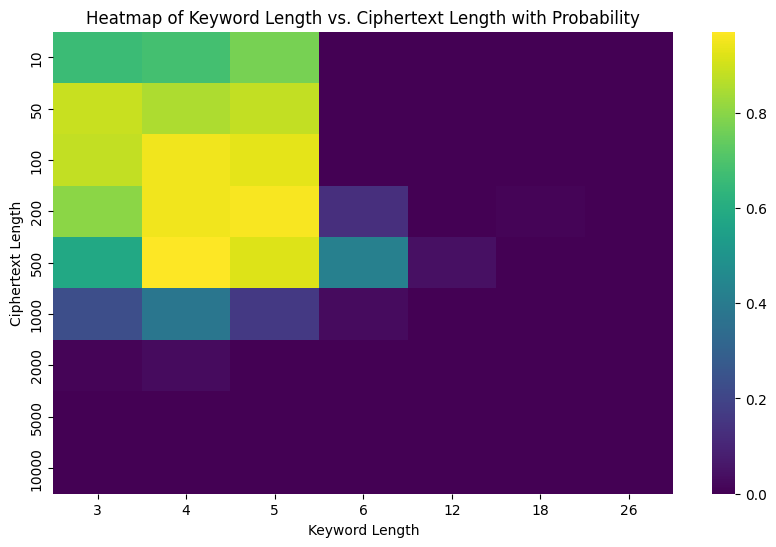

In [479]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data in the format of (keyword_len, ciphertext_len, probability)
data = result

# Extract x, y, and color values
x = [item[0] for item in data]
y = [item[1] for item in data[::-1]]
color = [item[2] for item in data]

# Create a DataFrame
import pandas as pd
df = pd.DataFrame({'Keyword Length': x, 'Ciphertext Length': y, 'Probability': color})

# Create a pivot table for the heatmap
pivot_table = df.pivot_table(index='Ciphertext Length', columns='Keyword Length', values='Probability')

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='viridis', fmt=".2f", cbar=True)

# Add labels and title
plt.xlabel('Keyword Length')
plt.ylabel('Ciphertext Length')
plt.title('Heatmap of Keyword Length vs. Ciphertext Length with Probability')

# Show the plot
plt.show()
